<a href="https://colab.research.google.com/github/yagoandres/dea_studies/blob/main/20250919_malmq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import relevant libraries
- Will use Pyomo for mathematical optimization
- Data source: Tom

# Malmquist Productivity Index, Technical Efficiency and Efficiency Change
## Energy

In [1]:
!apt-get install -y -qq glpk-utils > /dev/null 2>&1

In [2]:
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
                           SolverFactory, minimize, maximize, NonNegativeReals,
                           ConstraintList, TerminationCondition)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Get the path to the glpsol executable
glpk_executable_path = '/usr/bin/glpsol'  # Update with the actual path if different

# Set the solver path in the SolverFactory call
solver = SolverFactory('glpk', executable=glpk_executable_path)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Data and Variables

We used data from two time periods, 2014 and 2022, to calculate the Malmquist Productivity Index (MPI) and its decomposition into technical change and efficiency change.



In [5]:
#uploaded = files.upload()
file_path = "/content/drive/MyDrive/Colab Notebooks/20250914_DEA_EnergySecurityPaper2.csv"
df = pd.read_csv(file_path)
df_2014 = df[df["year"] == 2014]
df_2022 = df[df["year"] == 2022]
df_2014[:5]

,Unnamed: 0,dmu,year,installed_capacity_per_capita,energy_diversification,energy_export,percentage_renewable,mwh_capita,gdp_capita,electrification,carbon_intensity
14,14,Argentina,2014,0.881,3794.220973,-14.067810,10.396,0.003288,12233.144412,100.0,424.13745
38,38,Australia,2014,2.078,4460.109549,185.555789,5.663,0.010496,62544.087377,100.0,734.18134
62,62,Brazil,2014,0.544,4316.643494,-14.281473,37.566,0.002951,12274.993969,99.7,192.93880
86,86,Canada,2014,3.908,3916.466444,66.764578,27.026,0.018324,50960.843117,100.0,188.86014
110,110,China,2014,1.006,5615.278555,-17.557385,9.690,0.004175,7781.065975,100.0,693.72760


In [6]:
hb = df[df['dmu'] == "Canada"]
hb[['carbon_intensity', 'gdp_capita']]

,carbon_intensity,gdp_capita
72,245.68580,24271.002056
73,255.64854,23822.096211
74,245.11914,24256.019234
75,251.63614,28301.864594
76,235.33836,32145.541262
77,225.01208,36383.660007
78,216.50806,40504.037098
79,227.75510,44660.083889
80,213.47484,46710.252686
81,204.32664,40874.883193


##Data Preparation and Normalization

Our analysis employs a Data Envelopment Analysis (DEA) framework to calculate the Malmquist Productivity Index (MPI) and its components. The input variables comprise population development, health workforce, women's education, water access, and nutrition indicators, while the output variable is child survival rates. All variables are log-transformed to address potential scale effects and heteroscedasticity.

In [7]:
# Select Inputs and outputs for the MPI, TE, and EC
inputs_2014 = df_2014[['installed_capacity_per_capita', 'energy_diversification',
                       'energy_export', 'percentage_renewable']].values
outputs_2014 = df_2014[['mwh_capita', 'gdp_capita', 'carbon_intensity']].values

inputs_2014 = df_2022[['installed_capacity_per_capita', 'energy_diversification',
                       'energy_export', 'percentage_renewable']].values
outputs_2014 = df_2022[['mwh_capita', 'gdp_capita', 'carbon_intensity']].values
#inputs_2022 = df_2022[['l_pop_dev', 'l_healthworkforce']].values
#outputs_2022 = df_2022[['l_childsurvival']].values

To ensure numerical stability and comparable scales across variables, we implement a robust normalization procedure that scales all input and output variables to the [0.1, 1] range. This normalization is achieved through the following transformation:

$\text{normalized_value} = 0.1 + (0.9 \times \frac{x - \min(x)}{\max(x) - \min(x)})$

where $min(x)$ and $max(x)$ represent the minimum and maximum values for each variable across all DMUs. This transformation ensures that all values remain strictly positive while maintaining relative differences.. The addition of 0.1 prevents potential numerical issues that could arise from zero values in the optimization process.

In [8]:
def normalize_data(data):
    """
    Normalize data using robust scaling
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1

    # Scale to [0.1, 1] range
    normalized = 0.1 + 0.9 * (data - min_vals) / range_vals
    return normalized

##Efficiency Measurement

We employ an output-oriented Constant Returns to Scale (CRS) DEA model to calculate technical efficiency scores. The model is formulated as a linear programming problem:

$$
\begin{align*}
\max & \quad \phi \\
\text{subject to:} & \\
& \sum_{i} \lambda_i x_{ij} \leq x_{0j} \quad \text{for all inputs } j \\
& \sum_{i} \lambda_i y_{ik} \geq \phi y_{0k} \quad \text{for all outputs } k \\
& \lambda_i \geq 0 \quad \text{for all DMUs } i
\end{align*}
$$

where:
- $\phi$ represents the output expansion factor (efficiency score)
- $\lambda_i$ are the intensity variables
- $x_{ij}$ and $y_{ik}$ are the inputs and outputs of the reference DMUs
- $x_{0j}$ and $y_{0k}$ are the inputs and outputs of the DMU under evaluation

To handle potential computational instabilities, we incorporate an epsilon value ($1\text{e-}6$) in the constraints and implement bounds on the efficiency scores ($1.0 \leq \phi \leq 10.0$).

In [9]:
def calculate_efficiency_crs(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using output-oriented CRS DEA model
    """
    # Normalize data
    norm_inputs = normalize_data(inputs)
    norm_outputs = normalize_data(outputs)
    norm_frontier_inputs = normalize_data(frontier_inputs)
    norm_frontier_outputs = normalize_data(frontier_outputs)

    efficiencies = []

    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.phi = Var(domain=NonNegativeReals, bounds=(1.0, 10.0), initialize=1.0)
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals, bounds=(0.0, 1.0))

        # Objective: maximize phi (output efficiency)
        model.obj = Objective(expr=model.phi, sense=maximize)

        # Constraints
        model.constraints = ConstraintList()

        # Input constraints with epsilon
        epsilon = 1e-6
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= norm_inputs[i, j] + epsilon
            )

        # Output constraints with epsilon
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >= model.phi * norm_outputs[i, j] - epsilon
            )

        try:
            result = solver.solve(model)

            if result.solver.termination_condition == TerminationCondition.optimal:
                eff_value = 1 / float(model.phi.value)  # Convert to efficiency score

                # Validate efficiency value
                if eff_value < 0.1 or eff_value > 1.0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                #print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

## Malmquist Productivity Index Calculation

The MPI is calculated between two time periods ($t$ and $t+1$) and decomposed into efficiency change and technical change components. Following Färe et al. (1994), the MPI is computed as:

$\text{MPI} = \text{Efficiency Change} \times \text{Technical Change}$

where:

$\text{Efficiency Change} = \frac{E(t+1,t+1)}{E(t,t)}$

$\text{Technical Change} = \sqrt{\left[\frac{E(t,t)}{E(t,t+1)} \times \frac{E(t+1,t)}{E(t+1,t+1)}\right]}$

$E(a,b)$ represents the efficiency score of period $a$ data relative to period $b$ technology frontier.

In [10]:
def calculate_mpi_with_decomposition(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices=None):
    """
    Calculate MPI and its decomposition
    """
    # Calculate efficiencies
    #print("\nCalculating period t efficiencies...")
    eff_t_t = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t, outputs_t, solver, dmu_indices)

    #print("\nCalculating period t+1 efficiencies...")
    eff_t1_t1 = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t1, outputs_t1, solver, dmu_indices)

    #print("\nCalculating cross-period efficiencies...")
    eff_t_t1 = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t1_t = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t, outputs_t, solver, dmu_indices)

    # Handle potential numerical issues
    epsilon = 1e-10
    eff_t_t = np.maximum(eff_t_t, epsilon)
    eff_t1_t1 = np.maximum(eff_t1_t1, epsilon)
    eff_t_t1 = np.maximum(eff_t_t1, epsilon)
    eff_t1_t = np.maximum(eff_t1_t, epsilon)

    # Calculate components
    efficiency_change = eff_t1_t1 / eff_t_t
    technical_change = np.sqrt((eff_t_t / eff_t_t1) * (eff_t1_t / eff_t1_t1))
    mpi = efficiency_change * technical_change

    return mpi, technical_change, efficiency_change

##Bootstrap Procedure

To assess the statistical reliability of our MPI estimates, we implement a bootstrap procedure with bias correction. The bootstrap process involves:

Random resampling with replacement from the original dataset
Recalculation of MPI and its components for each bootstrap sample
Construction of bias-corrected confidence intervals

For each DMU, we calculate bias-corrected confidence intervals at the $α = 0.05$ significance level using $n = 1,000$ bootstrap iterations.

The bias correction adjusts the percentile selection based on the relationship between the bootstrap mean and the original estimate:

# Bias Correction for Percentile Selection

The bias correction adjusts the percentile selection based on the relationship between the bootstrap mean and the original estimate:

If $\text{bootstrap_mean} < \text{original_estimate}$:
- $\text{lower_percentile} = \max(\alpha/2, \alpha)$
- $\text{upper_percentile} = 1 - \alpha/2$

Otherwise:
- $\text{lower_percentile} = \alpha/2$
- $\text{upper_percentile} = 1 - \alpha/2$

This approach provides more conservative confidence intervals when bootstrap estimates suggest potential bias in the original calculations.

In [11]:
def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=1000, alpha=0.05):
    """
    Perform bootstrap with corrected confidence interval calculation
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    # Calculate original values
    mpi_orig, tech_orig, eff_orig = calculate_mpi_with_decomposition(
        inputs_t, outputs_t, inputs_t1, outputs_t1, solver
    )

    for b in range(n_bootstrap):
        #print(f"\nBootstrap iteration {b+1}/{n_bootstrap}")
        indices = np.random.choice(n_dmus, size=n_dmus, replace=True)

        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate bias-corrected confidence intervals
    mpi_ci = np.zeros((2, n_dmus))
    tech_ci = np.zeros((2, n_dmus))
    eff_ci = np.zeros((2, n_dmus))

    for i in range(n_dmus):
        # For each index, calculate bias-corrected intervals
        mpi_bias = np.mean(mpi_boots[:, i]) - mpi_orig[i]
        mpi_sorted = np.sort(mpi_boots[:, i])

        # Adjust percentiles based on bias
        if mpi_bias < 0:
            # If bootstrap mean is less than original, adjust lower bound
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            # If bootstrap mean is greater, use standard percentiles
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        mpi_ci[:, i] = [mpi_sorted[lower_idx], mpi_sorted[upper_idx]]

        # Repeat for technical change and efficiency change
        tech_bias = np.mean(tech_boots[:, i]) - tech_orig[i]
        tech_sorted = np.sort(tech_boots[:, i])

        if tech_bias < 0:
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        tech_ci[:, i] = [tech_sorted[lower_idx], tech_sorted[upper_idx]]

        eff_bias = np.mean(eff_boots[:, i]) - eff_orig[i]
        eff_sorted = np.sort(eff_boots[:, i])

        if eff_bias < 0:
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        eff_ci[:, i] = [eff_sorted[lower_idx], eff_sorted[upper_idx]]

    return mpi_ci, tech_ci, eff_ci



##Implementation

The analysis is implemented using Python 3.x, leveraging the Pyomo optimization framework for DEA calculations and NumPy for numerical computations. The GLPK solver is employed for solving the linear programming problems. To ensure solution reliability, we implement multiple safeguards:

- Validation of efficiency scores $(0.1 ≤ efficiency ≤ 1.0)$
- Handling of non-optimal solutions
- Error trapping for solver failures
- Minimum threshold $(ε = 1e-10)$ for efficiency scores to prevent division by zero

The complete analysis pipeline does the following:
- processes the data in parallel for both time periods,
- calculates the MPI and its decomposition,
- and performs the bootstrap procedure to generate confidence intervals for all metrics.

In [12]:
def run_analysis(df):
    """
    Run the complete MPI analysis
    """
    # Initialize solver
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

    # Split data by year

    df_2014 = df[df['year'] == 2014]
    df_2022 = df[df['year'] == 2022]
    df_2014 = df[df['year'] == 2014]

    # Prepare inputs and outputs

    input_cols = ['installed_capacity_per_capita', 'energy_diversification',
                       'energy_export', 'percentage_renewable']
    output_cols = ['mwh_capita', 'gdp_capita', 'carbon_intensity']

    #input_cols = ['l_pop_dev', 'l_healthworkforce', 'l_women_education',
    #             'l_water', 'l_better_nutrition']
    #output_cols = ['l_childsurvival']

    inputs_2014 = df_2014[input_cols].values
    outputs_2014 = df_2014[output_cols].values
    inputs_2022 = df_2022[input_cols].values
    outputs_2022 = df_2022[output_cols].values

    # Print data info
    print("\nData shapes:")
    print(f"2014 data: {df_2014.shape}")
    print(f"2022 data: {df_2022.shape}")

    # Calculate base MPI and decomposition
    print("\nCalculating base MPI...")
    mpi, tech_change, eff_change = calculate_mpi_with_decomposition(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver
    )

    # Calculate bootstrap confidence intervals
    print("\nCalculating bootstrap confidence intervals...")
    mpi_ci, tech_ci, eff_ci = bootstrap_mpi(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver,
        n_bootstrap=100  # Reduced number of bootstrap iterations
    )

    # Create results DataFrame
    results = pd.DataFrame({
        'DMU': df_2014['dmu'],
        'MPI': mpi,
        'MPI_CI_Lower': mpi_ci[0],
        'MPI_CI_Upper': mpi_ci[1],
        'Technical_Change': tech_change,
        'Tech_CI_Lower': tech_ci[0],
        'Tech_CI_Upper': tech_ci[1],
        'Efficiency_Change': eff_change,
        'Eff_CI_Lower': eff_ci[0],
        'Eff_CI_Upper': eff_ci[1]
    })

    # Add summary statistics
    summary_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
        'MPI': [results['MPI'].mean(), results['MPI'].median(),
                results['MPI'].std(), results['MPI'].min(), results['MPI'].max()],
        'Technical_Change': [results['Technical_Change'].mean(), results['Technical_Change'].median(),
                           results['Technical_Change'].std(), results['Technical_Change'].min(),
                           results['Technical_Change'].max()],
        'Efficiency_Change': [results['Efficiency_Change'].mean(), results['Efficiency_Change'].median(),
                            results['Efficiency_Change'].std(), results['Efficiency_Change'].min(),
                            results['Efficiency_Change'].max()]
    })

    return results, summary_stats

# Usage
if __name__ == "__main__":
    # Load data
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/20250914_DEA_EnergySecurityPaper2.csv")
    #df = pd.read_stata(io.BytesIO(uploaded["trial_data.dta"]))
    # Run analysis
    #file_path = "/content/20250914_DEA_EnergySecurityPaper2.xlsx"

    print(df.shape)
    print(df.head())
    print("here")
    df_2014 = df[df['year'] == 2014]
    #df["year" == 2014]
    print("after")

    results, summary = run_analysis(df)

    # Save results
    results.to_csv("mpi_results.csv", index=False)
    summary.to_csv("mpi_summary.csv", index=False)

(480, 11)
   Unnamed: 0        dmu  year  installed_capacity_per_capita  \
0           0  Argentina  2000                          0.720   
1           1  Argentina  2001                          0.745   
2           2  Argentina  2002                          0.743   
3           3  Argentina  2003                          0.741   
4           4  Argentina  2004                          0.738   

   energy_diversification  energy_export  percentage_renewable  mwh_capita  \
0             4114.315134      33.842833                11.557    0.002396   
1             4016.492525      44.465803                15.036    0.002583   
2             4154.941646      44.631023                15.335    0.002697   
3             4108.333120      40.307737                13.613    0.002863   
4             4037.284172      28.031842                11.465    0.002837   

    gdp_capita  electrification  carbon_intensity  
0  7637.014892             95.7         355.47310  
1  7141.475077            

## Results
- Inspect the results including the summary data
- Generate a few visualizations
- Export the results to CSV

In [13]:
pd.DataFrame(summary)

,Statistic,MPI,Technical_Change,Efficiency_Change
0,Mean,0.965703,0.965689,1.002322
1,Median,1.000000,0.999999,1.000001
2,Std Dev,0.047166,0.054185,0.063997
3,Min,0.854461,0.864704,0.850206
4,Max,1.024457,1.063111,1.184748


In [14]:
pd.DataFrame(results)[:10]

,DMU,MPI,MPI_CI_Lower,MPI_CI_Upper,Technical_Change,Tech_CI_Lower,Tech_CI_Upper,Efficiency_Change,Eff_CI_Lower,Eff_CI_Upper
14,Argentina,0.934712,0.798806,1.082899,0.881377,0.858392,1.070153,1.060514,0.862312,1.123068
38,Australia,0.980814,0.850498,1.179784,0.980814,0.882403,1.056170,1.000000,0.878672,1.177033
62,Brazil,0.854461,0.803283,1.019945,0.970878,0.871020,1.087346,0.880091,0.804471,1.065850
86,Canada,0.903863,0.824695,1.002929,1.063111,0.884191,1.056868,0.850206,0.808675,1.067835
110,China,0.929318,0.867178,1.122715,0.923631,0.854941,1.090579,1.006157,0.989434,1.185488
134,EU27,1.000000,0.870999,1.111240,1.000000,0.885410,1.063844,1.000001,0.881032,1.108831
158,France,0.905512,0.867882,1.082899,0.898284,0.880981,1.070153,1.008047,0.917926,1.092473
182,Germany,1.000001,0.860092,1.088208,0.999999,0.886832,1.064886,1.000001,0.860787,1.183110
206,India,1.000000,0.881286,1.101242,1.000000,0.898979,1.064607,1.000000,0.850446,1.179531
230,Indonesia,1.000000,0.849320,1.175228,1.000000,0.895546,1.067008,1.000000,0.870958,1.206871


### Generate visualization for MPI

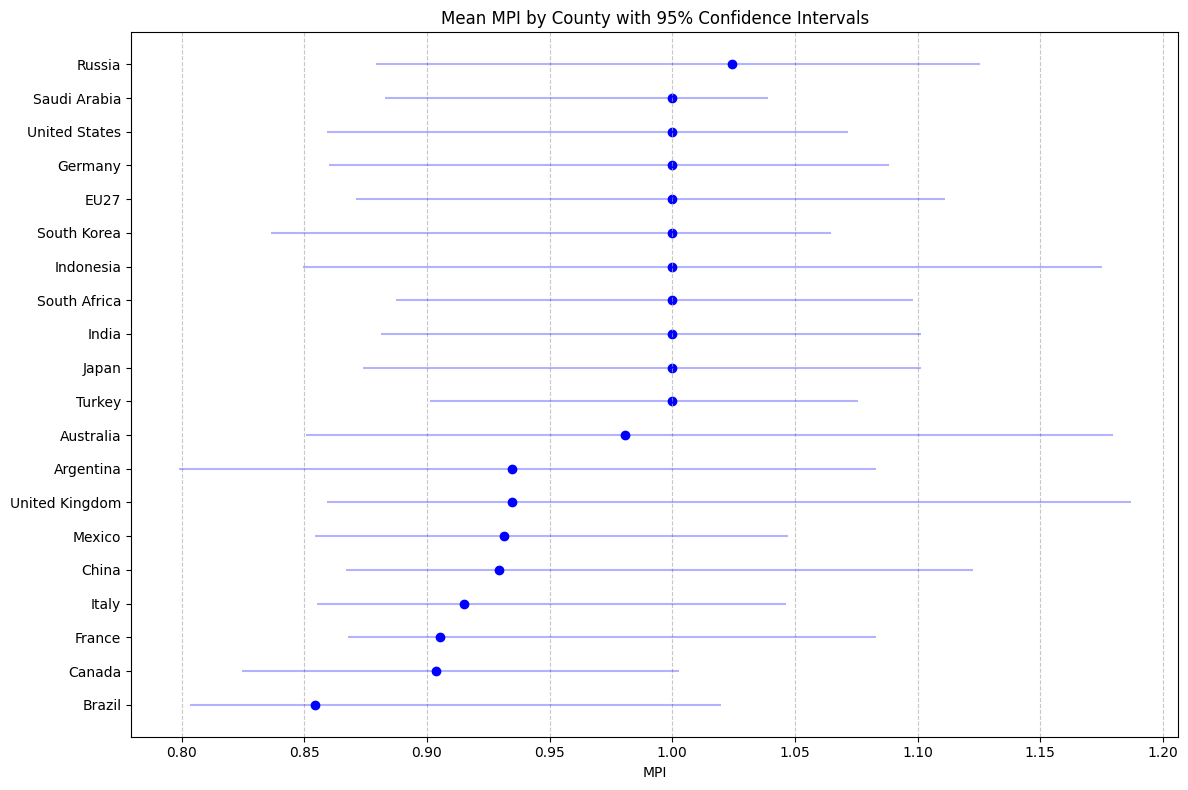

In [15]:
df3 = pd.DataFrame(results)
# Sort by mean MPI to make the plot more readable
df4 = df3.sort_values('MPI', ascending=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean GDP points
ax.scatter(df4['MPI'], range(len(df4)), color='blue', label='Mean GDP')

# Plot the confidence intervals
for idx, row in df4.iterrows():
    ax.hlines(y=df4.index.get_loc(idx),
              xmin=row['MPI_CI_Lower'],
              xmax=row['MPI_CI_Upper'],
              color='blue',
              alpha=0.3)

# Customize the plot
ax.set_yticks(range(len(df4)))
ax.set_yticklabels(df4['DMU'])
ax.set_xlabel('MPI')
ax.set_title('Mean MPI by County with 95% Confidence Intervals')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()
# Show the plot
plt.show()

### Generate visualization for technical efficiency

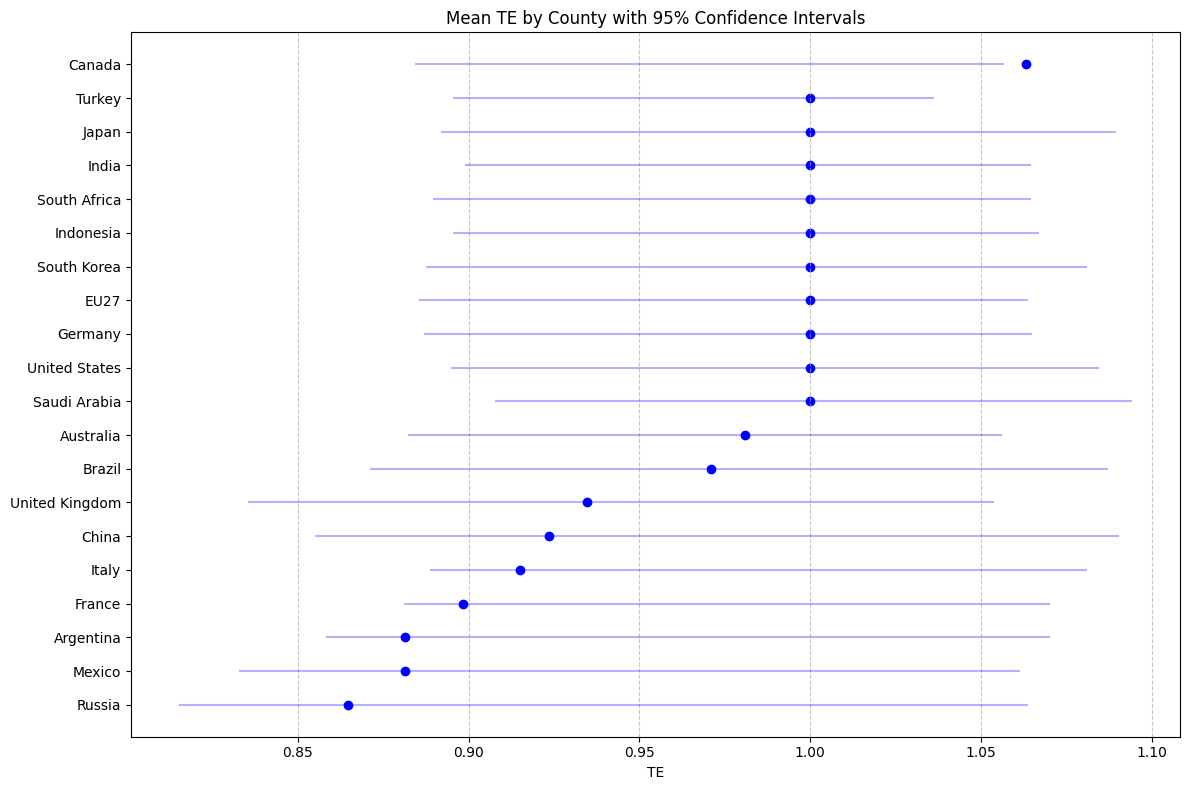

In [16]:
df4 = df3.sort_values('Technical_Change', ascending=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean tE points
ax.scatter(df4['Technical_Change'], range(len(df4)), color='blue', label='Mean GDP')

# Plot the confidence intervals
for idx, row in df4.iterrows():
    ax.hlines(y=df4.index.get_loc(idx),
              xmin=row['Tech_CI_Lower'],
              xmax=row['Tech_CI_Upper'],
              color='blue',
              alpha=0.3)

# Customize the plot
ax.set_yticks(range(len(df4)))
ax.set_yticklabels(df4['DMU'])
ax.set_xlabel('TE')
ax.set_title('Mean TE by County with 95% Confidence Intervals')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot

plt.show()

### Generate visualization for efficiency change

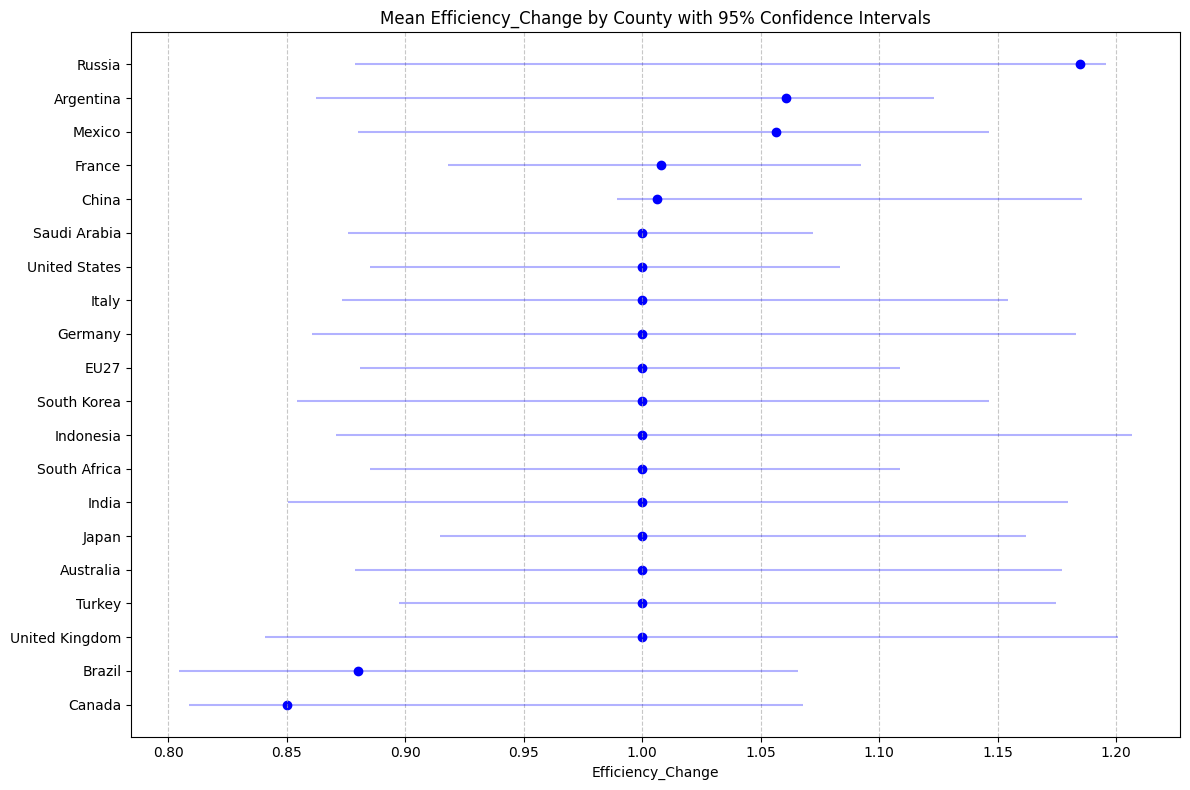

In [17]:
# Sort by mean EC to make the plot more readable
df4 = df3.sort_values('Efficiency_Change', ascending=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean EC points
ax.scatter(df4['Efficiency_Change'], range(len(df4)), color='blue', label='Mean GDP')

# Plot the confidence intervals
for idx, row in df4.iterrows():
    ax.hlines(y=df4.index.get_loc(idx),
              xmin=row['Eff_CI_Lower'],
              xmax=row['Eff_CI_Upper'],
              color='blue',
              alpha=0.3)

# Customize the plot
ax.set_yticks(range(len(df4)))
ax.set_yticklabels(df4['DMU'])
ax.set_xlabel('Efficiency_Change')
ax.set_title('Mean Efficiency_Change by County with 95% Confidence Intervals')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot

plt.show()

In [18]:
files.download("mpi_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
files.download("mpi_summary.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
!jupyter nbconvert --to html "/content/gdrive/My Drive/Colab Notebooks/20250919_malmq.ipynb"

[NbConvertApp] Converting notebook /content/gdrive/My Drive/Colab Notebooks/20250919_malmq.ipynb to html
[NbConvertApp] Writing 381199 bytes to /content/gdrive/My Drive/Colab Notebooks/20250919_malmq.html


In [22]:
!pwd

/content
